In [1]:
from typing import Tuple, Any

import pandas as pd
import numpy as np
import joblib
from termcolor import colored
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    precision_score,
    recall_score,
    accuracy_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

In [2]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [3]:
X_train = train_data.iloc[:, :-1]
Y_train = train_data.iloc[:, -1:]

X_test = test_data.iloc[:, :-1]
Y_test = test_data.iloc[:, -1:]

We divide X_train data into model training data and model validation data. We use data for model validation so as not to compromise the data for testing when determining the parameters of various models

In [4]:
(X_train, X_val, Y_train, Y_val) = train_test_split(X_train, Y_train, test_size=0.20, random_state=42, stratify=Y_train)

In [5]:
def score_model(Y_true: pd.DataFrame, Y_pred: np.ndarray) -> Tuple[float, float, float, float]:
    precision = precision_score(Y_true, Y_pred)
    recall = recall_score(Y_true, Y_pred)
    accuracy = accuracy_score(Y_true, Y_pred)
    f1 = f1_score(Y_true, Y_pred)

    return (precision, recall, accuracy, f1)

In [6]:
def report(model: Any, X_test: pd.DataFrame, Y_test: pd.Series, text: str = 'training') -> None:
    Y_pred = model.predict(X_test)

    print(colored(f'Classification report for model {type(model).__name__} on {text} data', 'green'))
    print('---------------------------------------------------------------------------------')
    print(classification_report(Y_test, Y_pred))
    print('---------------------------------------------------------------------------------')

    print(colored(f'Confusion matrix for model {type(model).__name__} on {text} data ', 'green'))
    print('---------------------------------------------------------------------------------')
    print(pd.DataFrame(confusion_matrix(Y_test, Y_pred), columns=['0', '1'], index=['0', '1']))
    print('---------------------------------------------------------------------------------')

# Training DecisionTreeClassifier

In [7]:
dtc_model = DecisionTreeClassifier()
dtc_model.fit(X_train, Y_train)

DecisionTreeClassifier()

In [8]:
report(dtc_model, X_train, Y_train, 'train')
report(dtc_model, X_test, Y_test, 'test')

Classification report for model DecisionTreeClassifier on train data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     15391
           1       1.00      1.00      1.00     15391

    accuracy                           1.00     30782
   macro avg       1.00      1.00      1.00     30782
weighted avg       1.00      1.00      1.00     30782

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on train data 
---------------------------------------------------------------------------------
       0      1
0  15355     36
1      6  15385
---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
             

Although the model seems to work perfectly on the training set, there has been some re-adjustment as shown by the results on the test set.

We are looking for the appropriate model that is the most efficient based on the hyper parameter.
It is important to note that we make predictions on the validation data so as not to compromise the test set

In [9]:
dtc_results = {}
dtc_cms = {}
depths = [2, 6, 10, 20, 40, 60, 80, 100, 120, 140, 160]

for depth in depths:
    dtc_model = DecisionTreeClassifier(max_depth=depth)
    dtc_model.fit(X_train, Y_train)

    Y_pred = dtc_model.predict(X_val)

    (precision, recall, accuracy, f1) = score_model(Y_val, Y_pred)

    dtc_results[depth] = {
        'precision': precision,
        'recall': recall,
        'accuracy': accuracy,
        'f1': f1
    }
    dtc_cms[depth] = confusion_matrix(Y_val, Y_pred)

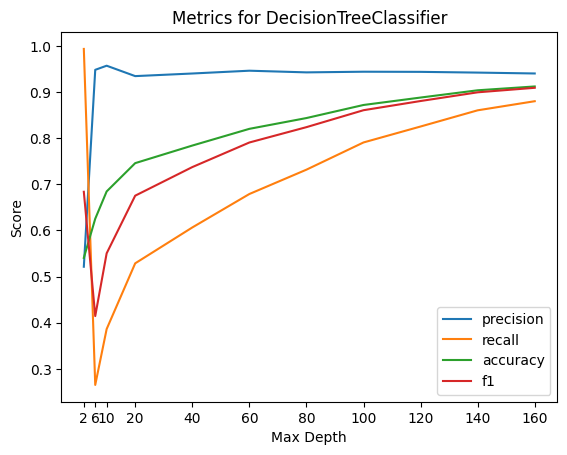

In [10]:
for metric in dtc_results[depths[0]].keys():
    plt.plot(depths, [dtc_results[key][metric] for key in dtc_results], label=metric)

plt.legend()
plt.title('Metrics for DecisionTreeClassifier')
plt.xlabel('Max Depth')
plt.ylabel('Score')
plt.xticks(depths)
plt.show()

In [11]:
for cm in dtc_cms:
    print(f'Depth: {cm}')
    print(f'{dtc_cms[cm][0][0]}\t{dtc_cms[cm][0][1]}')
    print(f'{dtc_cms[cm][1][0]}\t{dtc_cms[cm][1][1]}')
    print('-------------')

Depth: 2
337	3511
26	3822
-------------
Depth: 6
3792	56
2828	1020
-------------
Depth: 10
3781	67
2362	1486
-------------
Depth: 20
3705	143
1814	2034
-------------
Depth: 40
3699	149
1515	2333
-------------
Depth: 60
3699	149
1236	2612
-------------
Depth: 80
3676	172
1033	2815
-------------
Depth: 100
3667	181
806	3042
-------------
Depth: 120
3658	190
673	3175
-------------
Depth: 140
3644	204
538	3310
-------------
Depth: 160
3632	216
462	3386
-------------


With the increase in the depth of the tree, we can see that the results become better. The number of hit for non-hatred instances is slowly decreasing, but the number of hit for hatred instances is growing significantly more. It can be seen from the attachment that the ratings for tweets that contain hate speech are significantly worse than tweets that do not contain hate speech, which is not surprising considering that our original set contained 93% of tweets that were characterized as not containing hate speech.

In [12]:
best_dtc_model = DecisionTreeClassifier(max_depth=160, criterion='gini')
best_dtc_model.fit(X_train, Y_train)

report(best_dtc_model, X_test, Y_test, 'test')

Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8245
           1       0.46      0.57      0.51       603

    accuracy                           0.93      8848
   macro avg       0.72      0.76      0.74      8848
weighted avg       0.93      0.93      0.93      8848

---------------------------------------------------------------------------------
Confusion matrix for model DecisionTreeClassifier on test data 
---------------------------------------------------------------------------------
      0    1
0  7848  397
1   259  344
---------------------------------------------------------------------------------
